In [1]:
# Making a Class so that we can run many experiments more easily with different params

In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# DEFINITION OF THE TASK

# The "rule input" to the sensory motor system, coming from PFC, currently takes the form of just a number, either 1.0 or 2.0
# 1.0 indicates to use vision and ignore audition, and 2.0 indicates to use audition and ignore vision
def rvis(): 
    return 1.0 # If the input to the sensory-motor system, x, has 1 <= x < 2 then use vision
def raud(): # If the input to the sensory-motor system, x, has x > 2 then use audition
    return 2.0
def rnull(): # We'll use rnull output to indicate waiting during the delay period
    return 0.0

# This is the function that will be used to evaluate whether the PFC outputs the correct rule for a given cue, and to train it to do so
def cue_to_rule_mapping_function(t, integer_input, end_time_of_delay): # Define a changing mapping from cues to rules
    
    if t >= end_time_of_delay: # We can use this type of conditioning to set up time-dependent cue-to-rule mappings
        
        r1 = tf.cond(tf.equal(integer_input, tf.constant(0, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
    
        r2 = tf.cond(tf.equal(integer_input, tf.constant(1, dtype = tf.float32)), true_fn = rvis, false_fn = rnull)
        
        r3 = tf.cond(tf.equal(integer_input, tf.constant(2, dtype = tf.float32)), true_fn = raud, false_fn = rnull)
        
        r4 = tf.cond(tf.equal(integer_input, tf.constant(3, dtype = tf.float32)), true_fn = raud, false_fn = rnull) 
    
        return tf.reduce_max([r1,r2,r3,r4])
    
    else:
        
        return tf.constant(rnull(), dtype=tf.float32)

In [4]:
# Function for evaluating correctness
def correctness(q, o, ina, inv, ctin, s, start_time_of_delay, end_time_of_delay, batch_size): # Arguments: time, PFC output list, auditory input list, vision input list, cue inputs timeline. session
    
    if q >= end_time_of_delay: # In this case, should be executing a rule
    
        c = []
        for e in range(batch_size):
            if (np.linalg.norm(inv[e,q] - o[q][e]) < np.linalg.norm(ina[e,q] - o[q][e]) and s.run(cue_to_rule_mapping_function(q, float(ctin[e,start_time_of_delay-1]), end_time_of_delay)) == 1.0):
                c.append("correct") # If the output coordinates are closer to the vision target than the auditory target and that's the right rule
            elif (np.linalg.norm(inv[e,q] - o[q][e]) > np.linalg.norm(ina[e,q] - o[q][e]) and s.run(cue_to_rule_mapping_function(q, float(ctin[e,start_time_of_delay-1]), end_time_of_delay)) == 2.0):
                c.append("correct") # If the output coordinates are closer to the auditory target than the vision target and that's the right rule
            else:
                c.append("incorrect")
        return c
    
    else: # In this case, should output something close to the origin coordinates (0,0)
        
        c = []
        for e in range(batch_size):
            if np.linalg.norm([0.0,0.0] - o[q][e]) < 0.01:
                c.append("correct")
            else:
                c.append("incorrect")
        return c

In [5]:
class MD_PFC_SM:
    
    def __init__(self, num_units_PFC = 70, num_hidden_sensorymotor = 30, PFC_output_dimensions = 25, num_units_MD_hidden1 = 20, num_units_MD_hidden2 = 15):
        print "Initializing..."
        self.num_units_PFC = num_units_PFC
        self.num_hidden_sensorymotor = num_hidden_sensorymotor
        self.num_units_MD_hidden1 = num_units_MD_hidden1
        self.num_units_MD_hidden2 = num_units_MD_hidden2
        self.PFC_output_dimensions = PFC_output_dimensions
        self.batch_size = 16
        self.dropout_keep_prob = 0.7
        
    def setup_task(self, num_timesteps, start_time_of_delay, end_time_of_delay):
        print "Setting up task and network..."
        self.num_timesteps = num_timesteps
        self.start_time_of_delay = start_time_of_delay
        self.end_time_of_delay = end_time_of_delay
        self.resting_prefactor = 0.03 # This scales the relative contribution of the waiting / inactive state to the loss function
        self.MD_sparsity_loss_prefactor = 0.0 # Relative contribution of L1 norm of MD hidden layer, to encourage sparisty, lateral-inhibition style
        self.build_network()
        
    def build_network(self):
        print "Building network..."
        # Define the network

        DO_SHARE = None # This is needed for the recurrency of the RNN, see: https://blog.evjang.com/2016/06/understanding-and-implementing.html

        PFC_state_previous = tf.contrib.rnn.LSTMBlockCell(num_units = self.num_units_PFC).zero_state(self.batch_size, tf.float32) # Initial state of PFC

        # This does one cycle of the PFC RNN
        def PFC_step(input_data, network_state):
            with tf.variable_scope("PFC", reuse=DO_SHARE):
                PFC_cell = tf.contrib.rnn.LSTMBlockCell(num_units = self.num_units_PFC)
                return PFC_cell(inputs = input_data, state = network_state) 

        # Cue inputs delivered INTO the PFC, e.g., high pass noise, UV light, and so forth, here defined currently as just an integer indiciating which cue
        self.cue_timeseries = tf.placeholder(shape=[self.batch_size, self.num_timesteps, 1], dtype=tf.float32, name = 'cues_timeseries')

        # Visual and audio targets input to the sensory-motor system, represented as just 2D coordinates, one for each, right now
        self.input_vis = tf.placeholder(shape=[self.batch_size, self.num_timesteps, 2], dtype=tf.float32, name = 'input_vis')
        self.input_aud = tf.placeholder(shape=[self.batch_size, self.num_timesteps, 2], dtype=tf.float32, name = 'input_aud')

        self.loss = 0 # This will accumulate contributions to the loss function
        self.outs = [] # Output coordinates from the sensory-motor system
        self.rules_chosen = [] # Rules input from the PFC to the sensory-motor system

        pre_delay_cue = self.cue_timeseries[:,self.start_time_of_delay - 1]

        PFC_state = tf.Variable(tf.contrib.rnn.LSTMBlockCell(num_units = self.num_units_PFC).zero_state(self.batch_size, tf.float32))

        for t in range(self.num_timesteps): # Iterating over time in the experiment, with batches implicitly being used at each time step

            current_cue = self.cue_timeseries[:,t] # This is the cue that gets fed into the PFC on this timestep

            with tf.variable_scope("MD", reuse=DO_SHARE):
                MD_hidden1 = tf.nn.dropout(tf.contrib.layers.fully_connected(PFC_state[0], self.num_units_MD_hidden1, activation_fn = tf.nn.relu), keep_prob = self.dropout_keep_prob)
                MD_hidden2 = tf.nn.dropout(tf.contrib.layers.fully_connected(MD_hidden1, self.num_units_MD_hidden2, activation_fn = tf.nn.relu), keep_prob = self.dropout_keep_prob)

            PFC_state = PFC_step(input_data = tf.concat([current_cue, MD_hidden2], axis=-1), network_state = PFC_state_previous)
            # The output from the PFC into the sensorymotor system gives information about the rule that the sensory-motor system is supposed to execute
            with tf.variable_scope("PFC_output", reuse=DO_SHARE):
                PFC_output = tf.nn.dropout(tf.contrib.layers.fully_connected(PFC_state[0], self.PFC_output_dimensions, activation_fn = None), keep_prob = self.dropout_keep_prob) # Note: this layer is linear
            self.rules_chosen.append(PFC_output) # The info sent by PFC to the sensory-motor system, corresponding to the chosen rule

            input_rule_to_sensorymotor_system = PFC_output # The rule output from the PFC is sent to the sensory-motor system
            input_total = tf.concat([self.input_vis[:,t], self.input_aud[:,t], input_rule_to_sensorymotor_system], axis = -1) # Sensory-motor system gets aud, vis & rule inputs

            with tf.variable_scope("hidden_sensorymotor", reuse=DO_SHARE):
                hidden_sensorymotor = tf.nn.dropout(tf.contrib.layers.fully_connected(input_total, self.num_hidden_sensorymotor, activation_fn = tf.nn.relu), keep_prob = self.dropout_keep_prob) # Sensory-motor hidden layer

            num_out_sensorymotor = 2 # These are the 2D coordinates that we want to sensory-motor system to produce
            with tf.variable_scope("out_sensorymotor", reuse=DO_SHARE):
                out_sensorymotor = tf.contrib.layers.fully_connected(hidden_sensorymotor, num_out_sensorymotor, activation_fn = tf.nn.relu) 
                # Output coord from sensory-motor system

            self.outs.append(out_sensorymotor)

            PFC_state_previous = PFC_state[1] # This is needed for the recurrency of the PFC RNN

            for e in range(self.batch_size): # Here is where we compute a contribution to the loss function for training
                cpred = pre_delay_cue[e][0] # The cue we are supposed to be holding on to in working memory
                cue_to_rule_mapping_function_output = cue_to_rule_mapping_function(t, cpred, self.end_time_of_delay) # The CORRECT rule to choose in the task
                if t >= self.end_time_of_delay: # We use this to set up time-dependent loss functions, e.g., only look at late times
                    loss_contrib1 = tf.cond(tf.equal(cue_to_rule_mapping_function_output, tf.constant(1, dtype = tf.float32)),\
                                            true_fn = lambda: tf.square(tf.norm(self.input_vis[e,t] - out_sensorymotor[e])),  false_fn = lambda: 0.0)
                    loss_contrib2 = tf.cond(tf.equal(cue_to_rule_mapping_function_output, tf.constant(2, dtype = tf.float32)),\
                                            true_fn = lambda: tf.square(tf.norm(self.input_aud[e,t] - out_sensorymotor[e])),  false_fn = lambda: 0.0)
                    # The last two lines define the loss function contribution at a given time, 
                    # here the proximity of the output coordinate to the visual input target OR the proximity to the auditory target,
                    # depending on the correct rule for this moment in the task
                    self.loss += (loss_contrib1 + loss_contrib2)
                else:
                    self.loss += self.resting_prefactor * tf.reduce_sum(tf.square(out_sensorymotor[e])) # Distance of the output from the origin...

                # MD loss function terms
                self.loss += self.MD_sparsity_loss_prefactor * tf.norm(MD_hidden1, ord = 1) # L1 norm of MD hidden layer, to encourage sparisty, lateral-inhibition style
                self.loss += self.MD_sparsity_loss_prefactor * tf.norm(MD_hidden2, ord = 1) # L1 norm of MD hidden layer, to encourage sparisty, lateral-inhibition style

            DO_SHARE = True # This is needed for the recurrency of the RNN, see: https://blog.evjang.com/2016/06/understanding-and-implementing.html

            print "Built timestep %i" % t
            
    def train(self, num_batches = 30000, learning_rate_PFC = 0.01, learning_rate_MD = 0.01, learning_rate_other = 0.01):
        print "Setting up training..."
        self.num_batches = num_batches
        self.learning_rate_PFC = learning_rate_PFC
        self.learning_rate_MD = learning_rate_MD
        self.learning_rate_other = learning_rate_other
        self.run_training()
    
    def run_training(self):
        print "Running training..."
        # Allowing different learning rates for PFC, MD and the rest of the network
        self.var_list_other = []
        for name in ["PFC_output", "hidden_sensorymotor", "out_sensorymotor"]:
            self.var_list_other.extend(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name))
        self.var_list_PFC = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "PFC")
        self.var_list_MD = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "MD")
        train_op_other = tf.train.GradientDescentOptimizer(self.learning_rate_other).minimize(self.loss, var_list=self.var_list_other) # Might want to replace with tf.train.AdamOptimizer
        train_op_PFC = tf.train.GradientDescentOptimizer(self.learning_rate_PFC).minimize(self.loss, var_list=self.var_list_PFC)
        train_op_MD = tf.train.GradientDescentOptimizer(self.learning_rate_MD).minimize(self.loss, var_list=self.var_list_MD)
        self.train_op = tf.group(train_op_other, train_op_PFC, train_op_MD)    

        # Setting up the session: standard TensorFlow boilerplate
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())
        
        # This is the cue timeseries input provided by the environment
        # Here random cues are delivered across time and within batch
        ct = np.reshape([np.random.randint(0,4) for k in range(self.num_timesteps * self.batch_size * self.num_batches)], [self.num_batches, self.batch_size, self.num_timesteps, 1])

        # Randomly chosen visual target coordinates
        in_vis_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(self.num_timesteps * self.batch_size * self.num_batches)] 
        in_vis_list = np.reshape(in_vis_list_unshaped, [self.num_batches,self.batch_size,self.num_timesteps, 2])

        # Randomly chosen auditory target coordinates
        in_aud_list_unshaped = [[np.random.rand(), np.random.rand()] for k in range(self.num_timesteps * self.batch_size * self.num_batches)]
        in_aud_list = np.reshape(in_aud_list_unshaped, [self.num_batches,self.batch_size,self.num_timesteps, 2])

        # Running the session and storing the loss function across batches to see the learning curve  
        self.losses = []
        for b in range(self.num_batches): # Running the training batches
            ct_in = ct[b, :, :]
            in_v = in_vis_list[b, :, :]
            in_a = in_aud_list[b, :, :]
            os, l, rc, _ = self.sess.run([self.outs, self.loss, self.rules_chosen, self.train_op], feed_dict = {self.cue_timeseries:ct_in, self.input_vis: in_v, self.input_aud:in_a})
            # The outputs here are just for the last batch only...
            self.losses.append(l)
            if b % 100 == 0:
                print "Ran training batch %i" % b
            
        self.os = os
        self.l = l
        self.rc = rc
        self.in_v = in_v
        self.in_a = in_a
        self.ct_in = ct_in
            
    def report_outputs(self, verbose = False):
        print "Outputs report..."
        # Printing the outputs for visual inspection
        print "Loss: %f" % self.l
        print "\n\n"

        def smooth(y, box_pts):
            box = np.ones(box_pts)/box_pts
            y_smooth = np.convolve(y, box, mode='same')
            return y_smooth

        # Plotting the loss function over time to see the learning process
        plt.figure()
        plt.plot(smooth(self.losses, 10))
        plt.title("Loss versus # batches")
        plt.show()
        
        # Text report from the last batch
        print "Last batch report..."
        rule_to_hold_onto = [self.sess.run(cue_to_rule_mapping_function(self.end_time_of_delay, float(self.ct_in[e,self.start_time_of_delay-1]), self.end_time_of_delay)) for e in range(self.batch_size)]
        for q in range(self.num_timesteps):
            print "timestep %i" % q
            if verbose:
                print "out", self.os[q][:], "\n", "vis in", self.in_v[:,q],"\n", "aud in", self.in_a[:, q],"\n", "PFC output", self.rc[q][:] 
                print "rule given cue just prior to delay period:", rule_to_hold_onto
            print "correctness:", correctness(q, self.os, self.in_a, self.in_v, self.ct_in, self.sess, self.start_time_of_delay, self.end_time_of_delay, self.batch_size) 
            print "\n"

Initializing...
Setting up task and network...
Building network...
Built timestep 0
Built timestep 1
Built timestep 2
Built timestep 3
Built timestep 4
Built timestep 5
Built timestep 6
Built timestep 7
Built timestep 8
Built timestep 9
Built timestep 10
Built timestep 11
Built timestep 12
Built timestep 13
Built timestep 14
Built timestep 15
Setting up training...
Running training...
Ran training batch 0
Outputs report...
Loss: 56.347507





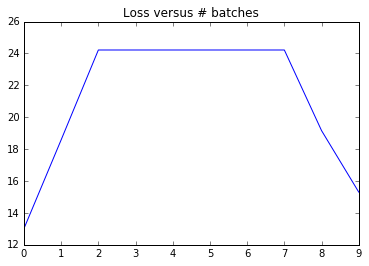

Last batch report...
timestep 0
correctness: ['incorrect', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'incorrect', 'incorrect']


timestep 1
correctness: ['incorrect', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'incorrect', 'incorrect', 'incorrect', 'correct', 'correct', 'incorrect', 'correct']


timestep 2
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'incorrect', 'incorrect', 'correct']


timestep 3
correctness: ['correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct']


timestep 4
correctness: ['incorrect', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'incorrect', 'correct', 'cor

In [6]:
# Illustrating how to run experiments with different parameters
md_pfc_sm_1 = MD_PFC_SM(num_units_PFC = 70, num_hidden_sensorymotor = 30, PFC_output_dimensions = 25, num_units_MD_hidden1 = 20, num_units_MD_hidden2 = 15)
md_pfc_sm_1.setup_task(num_timesteps = 16, start_time_of_delay = 6, end_time_of_delay = 11)
md_pfc_sm_1.train(num_batches = 5, learning_rate_PFC = 0.0001, learning_rate_MD = 0.1, learning_rate_other = 0.01)
md_pfc_sm_1.report_outputs(verbose = False)

Initializing...
Setting up task and network...
Building network...
Built timestep 0
Built timestep 1
Built timestep 2
Built timestep 3
Built timestep 4
Built timestep 5
Built timestep 6
Built timestep 7
Built timestep 8
Built timestep 9
Built timestep 10
Built timestep 11
Built timestep 12
Built timestep 13
Built timestep 14
Built timestep 15
Setting up training...
Running training...
Ran training batch 0
Outputs report...
Loss: 53.311390





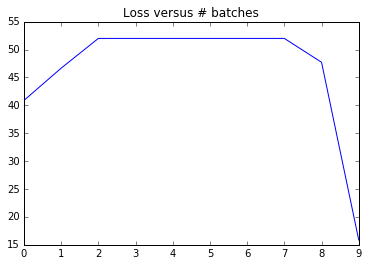

Last batch report...
timestep 0
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']


timestep 1
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']


timestep 2
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']


timestep 3
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct']


timestep 4
correctness: ['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct',

In [7]:
tf.reset_default_graph() # Use this before each subsequent run after the first run

md_pfc_sm_2 = MD_PFC_SM(num_units_PFC = 70, num_hidden_sensorymotor = 30, PFC_output_dimensions = 25, num_units_MD_hidden1 = 20, num_units_MD_hidden2 = 15)
md_pfc_sm_2.setup_task(num_timesteps = 16, start_time_of_delay = 6, end_time_of_delay = 11)
md_pfc_sm_2.train(num_batches = 5, learning_rate_PFC = 0.01, learning_rate_MD = 0.01, learning_rate_other = 0.01)
md_pfc_sm_2.report_outputs(verbose = False)